<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Modeling
</h1>

<h3 style="color:#555; text-align:left;">
    Algorithms, Train and Validation, hyperparametrization and model comparison
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1 Libraries and Data importation**
## **1.1 Import Libraries**

In [1]:
# --- System utilities ---
import os
import sys
import json
import joblib
from datetime import datetime

# --- Data manipulation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn base utilities ---
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

# --- Scikit-learn models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- XGBoost ---
from xgboost import XGBClassifier

# --- Optuna ---
import optuna
from optuna.trial import TrialState


c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 Import paths to files**

In [2]:
def load_all_processed_data(path: str = "../data/processed"):
    """
    Load all processed data and feature selections from the given path.
    """
    data = {}

    # ============================
    # Base data
    # ============================
    data["X"] = pd.read_parquet(f"{path}/X.parquet")
    data["X_enc"] = pd.read_parquet(f"{path}/X_encoded.parquet")
    data["y"] = pd.read_csv(f"{path}/y.csv")

    # ============================
    # StratifiedKFold parameters
    # ============================
    with open(f"{path}/spkf_params.json", "r") as f:
        skf_params = json.load(f)

    data["skf"] = StratifiedKFold(
        n_splits=skf_params["n_splits"],
        shuffle=skf_params["shuffle"],
        random_state=skf_params["random_state"],
    )

    # ============================
    # Embedded methods - feature lists
    # ============================
    embedded_feature_lists = {
        "xgb_selected_features_embeded": "xgb_selected_features_embeded.json",
        "rf_selected_features_embeded": "rf_selected_features_embeded.json",
        "log_selected_features_embeded": "log_selected_features_embeded.json",
        "dt_selected_features_embeded": "dt_selected_features_embeded.json",
        "log_l1_selected_features_embeded": "log_l1_selected_features_embeded.json",
        "consensus_3of3_embeded": "consensus_3of3_embeded.json",
        "consensus_2of3_embeded": "consensus_2of3_embeded.json",
        "consensus_topN_embeded": "consensus_topN_embeded.json",
    }

    for key, filename in embedded_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Embedded methods - datasets
    embedded_datasets = {
        "X_xgb_embeded": "X_xgb_embeded.parquet",
        "X_rf_embeded": "X_rf_embeded.parquet",
        "X_log_embeded": "X_log_wrapper.parquet",
        "X_dt_embeded": "X_dt_embeded.parquet",
        "X_log_l1_embeded": "X_log_l1_embeded.parquet",
    }

    for key, filename in embedded_datasets.items():
        data[key] = pd.read_parquet(f"{path}/{filename}")

    # ============================
    # Wrapper methods - feature lists
    # ============================
    wrapper_feature_lists = {
        "xgb_selected_features_wrapper": "xgb_selected_features_wrapper.json",
        "rf_selected_features_wrapper": "rf_selected_features_wrapper.json",
        "log_selected_features_wrapper": "log_selected_features_wrapper.json",
        "dt_wrap_selected_features_wrapper": "dt_wrap_selected_features_wrapper.json",
        "consensus_3of3_wrapper": "consensus_3of3_wrapper.json",
        "consensus_2of3_wrapper": "consensus_2of3_wrapper.json",
        "consensus_topN_wrapper": "consensus_topN_wrapper.json",
    }

    for key, filename in wrapper_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Wrapper methods - datasets
    wrapper_datasets = {
        "X_xgb_wrapper": "X_xgb_wrapper.parquet",
        "X_rf_wrapper": "X_rf_wrapper.parquet",
        "X_log_wrapper": "X_log_wrapper.parquet",
        "X_dt_wrap_wrapper": "X_dt_wrap_wrapper.parquet",
    }

    for key, filename in wrapper_datasets.items():
        data[key] = pd.read_parquet(f"{path}/{filename}")

    return data


## **1.3 Load files to dataframes**

In [3]:
# =============================================================
# Load information about Data
# =============================================================

data = load_all_processed_data()

X = data["X"]
X_enc = data["X_enc"]
y = data["y"]
y = y.squeeze()


# =============================================================
# Load information about Data Separation
# =============================================================

skf = data["skf"]

# =============================================================
# Load specific selected features datasets by Embeded Methods
# =============================================================

# Embedded – listas de features
xgb_selected_features_embeded = data["xgb_selected_features_embeded"]
rf_selected_features_embeded = data["rf_selected_features_embeded"]
log_selected_features_embeded = data["log_selected_features_embeded"]

consensus_3of3_embeded = data["consensus_3of3_embeded"]
consensus_2of3_embeded = data["consensus_2of3_embeded"]
consensus_topN_embeded = data["consensus_topN_embeded"]

# Embedded – datasets
#X_xgb_embeded = data["X_xgb_embeded"]
#X_rf_embeded = data["X_rf_embeded"]
#X_log_embeded = data["X_log_embeded"]

# =============================================================
# Load specific selected features datasets by Wrapper Methods
# =============================================================

# Wrapper – listas de features
xgb_selected_features_wrapper = data["xgb_selected_features_wrapper"]
rf_selected_features_wrapper = data["rf_selected_features_wrapper"]
log_selected_features_wrapper = data["log_selected_features_wrapper"]

consensus_3of3_wrapper = data["consensus_3of3_wrapper"]
consensus_2of3_wrapper = data["consensus_2of3_wrapper"]
consensus_topN_wrapper = data["consensus_topN_wrapper"]

# Wrapper – datasets
#X_xgb_wrapper = data["X_xgb_wrapper"]
#X_rf_wrapper = data["X_rf_wrapper"]
#X_log_wrapper = data["X_log_wrapper"]

## **1.4 Creating dataframes to be tested**

In [4]:
#Subset 1: all_data
all_data_enc = pd.concat([X_enc, y], axis=1)

#Subset 2: Embedded features
df_xgb_selected_features_embeded = pd.concat([X_enc[xgb_selected_features_embeded], y], axis=1)
df_rf_selected_features_embeded = pd.concat([X_enc[rf_selected_features_embeded], y], axis=1)
df_log_selected_features_embeded = pd.concat([X_enc[log_selected_features_embeded], y], axis=1)

df_consensus_3of3_embeded = pd.concat([X_enc[consensus_3of3_embeded], y], axis=1)
df_consensus_2of3_embeded = pd.concat([X_enc[consensus_2of3_embeded], y], axis=1)
df_consensus_topN_embeded = pd.concat([X_enc[consensus_topN_embeded], y], axis=1)

#Subset 3: Wrapper features
df_xgb_selected_features_wrapper = pd.concat([X_enc[xgb_selected_features_wrapper], y], axis=1)
df_rf_selected_features_wrapper = pd.concat([X_enc[rf_selected_features_wrapper], y], axis=1)
df_log_selected_features_wrapper = pd.concat([X_enc[log_selected_features_wrapper], y], axis=1)

df_consensus_3of3_wrapper = pd.concat([X_enc[consensus_3of3_wrapper], y], axis=1)
df_consensus_2of3_wrapper = pd.concat([X_enc[consensus_2of3_wrapper], y], axis=1)
df_consensus_topN_wrapper = pd.concat([X_enc[consensus_topN_wrapper], y], axis=1)

# dictionary with all feature subsets
subsets = {
    "all_data_enc": X_enc,

    # Embedded features
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper features
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}



# **2 Model Selection**
## **2.1 Auxiliary Functions to deal with Model Selection**

### **2.1.1 Encode Data**

In [5]:
def encode_data(dataset, to_encode_cols):

    ########################################## CREATE DUMMIES #################################################
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    # 1. Criar dummies
    dummies = pd.get_dummies(dataset[to_encode_cols], drop_first=True)
    # 2. Remover colunas originais
    dataset_remaining = dataset.drop(columns=to_encode_cols)
    # 3. Juntar tudo
    final_dataset = pd.concat([dataset_remaining, dummies], axis=1)
    return final_dataset

### **2.1.2 Sub to train models**

In [6]:
def select_best_models(X_enc, y, model, skf, scale: bool=True):

    score_train, score_val = [],[]

    # perform the cross-validation
    for train_index, val_index in skf.split(X_enc,y):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if scale:
            # scale the data
            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)

        # apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

### **2.1.3 Sub to show results**

In [7]:
def show_results(df, X_enc, y, skf, models, scales):
    """
    df      : DataFrame onde vais guardar os resultados (uma linha por modelo)
    X_enc   : feature matrix já encodada
    y       : target (0/1)
    skf     : StratifiedKFold
    models  : lista de modelos [model_XGB, model_RF, model_LOG, ...]
    scales  : lista de bools [False, False, True, ...] se precisa de scaling
    """
    for i, model in enumerate(models):
        scale_flag = scales[i]
        avg_train, std_train, avg_val, std_val = select_best_models(
            X_enc, y, model, skf, scale=scale_flag
        )
        df.iloc[i] = (
            f"{avg_train} +/- {std_train}",
            f"{avg_val} +/- {std_val}"
        )
    return df


## **2.2 Model Instances**
### **2.2.1 XGBoost**

In [8]:
#calculos auxiliares para lidar com desbalanceamento
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

model_XGB = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=99,
    n_jobs=-1
)


### **2.2.2 Random Forest**

In [9]:
model_RF = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=99,
    n_jobs=-1,
    class_weight="balanced_subsample"  # ativa isto se o target estiver desequilibrado
)


### **2.2.3 Logistic Regression (with StandardScaler)**

In [10]:
model_LOG = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=99
    ))
])


## **2.3 Model Training**

In [11]:
results = {}

results["XGB"] = select_best_models(X_enc, y, model_XGB, skf, scale=False)
results["RF"] = select_best_models(X_enc, y, model_RF, skf, scale=False)
results["LOG"] = select_best_models(X_enc, y, model_LOG, skf, scale=True)


In [12]:
"Create a Dataframe with the columns ['Train', 'Validation] and the index [XGB','RF','LOG'] named as df_all."
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['XGB','RF','LOG'])

In [13]:
# =======================================
# 0. Ensure output folder exists
# =======================================

output_dir = "../data/processed/Initial_Model_results"
os.makedirs(output_dir, exist_ok=True)

# =======================================
# 1. Build dictionary of subsets (encoded only)
# =======================================

subsets_for_models = {
    "all_data_enc": X_enc,

    # Embedded subsets
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper subsets
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}

# =======================================
# 2. Evaluate all models on all subsets
# =======================================

models = [model_XGB, model_RF, model_LOG]
scales = [False, False, True]

all_results_list = []

for subset_name, X_sub in subsets_for_models.items():
    print(f"Running models for subset: {subset_name} (shape={X_sub.shape})")

    tmp_results = pd.DataFrame(
        index=["XGB", "RF", "LOG"],
        columns=["Train F1", "Validation (F1)"]
    )

    tmp_results = show_results(tmp_results, X_sub, y, skf, models, scales)

    tmp_results["Subset"] = subset_name
    tmp_results["Model"] = tmp_results.index

    all_results_list.append(tmp_results.reset_index(drop=True))

# =======================================
# 3. Final results table
# =======================================

final_results = pd.concat(all_results_list, ignore_index=True)
final_results = final_results[["Subset", "Model", "Train F1", "Validation (F1)"]]
final_results.set_index(["Subset", "Model"], inplace=True)

# =======================================
# 4. Timestamp
# =======================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =======================================
# 5. Save results inside folder
# =======================================

#results_csv = os.path.join(output_dir, f"final_results_{timestamp}.csv")
results_xlsx = os.path.join(output_dir, f"final_results_{timestamp}.xlsx")

#features_csv = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.csv")
features_xlsx = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.xlsx")

# Save model results
#final_results.to_csv(results_csv)
final_results.to_excel(results_xlsx)

# Save feature compositions
subset_feature_dict = {}

subset_feature_dict["all_data"] = list(X.columns)
subset_feature_dict["all_data_enc"] = list(X_enc.columns)

for name, df in subsets_for_models.items():
    subset_feature_dict[name] = list(df.columns)

subset_feature_df = (
    pd.DataFrame.from_dict(subset_feature_dict, orient="index")
    .transpose()
)

#subset_feature_df.to_csv(features_csv, index=False)
subset_feature_df.to_excel(features_xlsx, index=False)

print("Saved files:")
#print(f" - {results_csv}")
print(f" - {results_xlsx}")
#print(f" - {features_csv}")
print(f" - {features_xlsx}")
final_results


Running models for subset: all_data_enc (shape=(7043, 33))
Running models for subset: xgb_embed (shape=(7043, 15))
Running models for subset: rf_embed (shape=(7043, 15))
Running models for subset: log_embed (shape=(7043, 15))
Running models for subset: consensus_3of3_embed (shape=(7043, 32))
Running models for subset: consensus_2of3_embed (shape=(7043, 33))
Running models for subset: consensus_topN_embed (shape=(7043, 20))
Running models for subset: xgb_wrapper (shape=(7043, 21))
Running models for subset: rf_wrapper (shape=(7043, 27))
Running models for subset: log_wrapper (shape=(7043, 28))
Running models for subset: consensus_3of3_wrapper (shape=(7043, 16))
Running models for subset: consensus_2of3_wrapper (shape=(7043, 27))
Running models for subset: consensus_topN_wrapper (shape=(7043, 25))
Saved files:
 - ../data/processed/Initial_Model_results\final_results_20251201_141209.xlsx
 - ../data/processed/Initial_Model_results\subset_feature_composition_20251201_141209.xlsx


Train F1 Validation (F1)
Subset                 Model                               
all_data_enc           XGB    0.811 +/- 0.0  0.721 +/- 0.01
                       RF       1.0 +/- 0.0  0.677 +/- 0.02
                       LOG    0.692 +/- 0.0  0.687 +/- 0.01
xgb_embed              XGB    0.766 +/- 0.0  0.712 +/- 0.01
                       RF       1.0 +/- 0.0  0.672 +/- 0.02
                       LOG    0.685 +/- 0.0  0.683 +/- 0.01
rf_embed               XGB      0.8 +/- 0.0  0.709 +/- 0.01
                       RF       1.0 +/- 0.0  0.667 +/- 0.02
                       LOG    0.671 +/- 0.0  0.668 +/- 0.01
log_embed              XGB    0.707 +/- 0.0  0.686 +/- 0.01
                       RF     0.765 +/- 0.0  0.662 +/- 0.01
                       LOG    0.677 +/- 0.0  0.676 +/- 0.01
consensus_3of3_embed   XGB    0.813 +/- 0.0  0.722 +/- 0.01
                       RF       1.0 +/- 0.0  0.675 +/- 0.03
                       LOG    0.692 +/- 0.0  0.687 +/- 0.01
consensus_2of3_embed   XGB    0.812 +/- 0.0  0.721 +/- 0.01
                       RF       1.0 +/- 0.0  0.678 +/- 0.02
                       LOG    0.692 +/- 0.0  0.687 +/- 0.01
consensus_topN_embed   XGB    0.803 +/- 0.0  0.719 +/- 0.01
                       RF       1.0 +/- 0.0  0.671 +/- 0.02
                       LOG    0.686 +/- 0.0  0.683 +/- 0.01
xgb_wrapper            XGB    0.795 +/- 0.0  0.723 +/- 0.01
                       RF       1.0 +/- 0.0  0.684 +/- 0.02
                       LOG    0.691 +/- 0.0   0.69 +/- 0.01
rf_wrapper             XGB     0.81 +/- 0.0  0.722 +/- 0.01
                       RF       1.0 +/- 0.0  0.672 +/- 0.02
                       LOG    0.688 +/- 0.0  0.686 +/- 0.01
log_wrapper            XGB    0.797 +/- 0.0  0.719 +/- 0.01
                       RF       1.0 +/- 0.0  0.678 +/- 0.02
                       LOG    0.692 +/- 0.0  0.689 +/- 0.01
consensus_3of3_wrapper XGB    0.785 +/- 0.0  0.721 +/- 0.02
                       RF       1.0 +/- 0.0  0.679 +/- 0.02
                       LOG    0.687 +/- 0.0  0.683 +/- 0.01
consensus_2of3_wrapper XGB    0.802 +/- 0.0  0.725 +/- 0.01
                       RF       1.0 +/- 0.0  0.679 +/- 0.02
                       LOG    0.691 +/- 0.0   0.69 +/- 0.01
consensus_topN_wrapper XGB    0.811 +/- 0.0   0.72 +/- 0.01
                       RF       1.0 +/- 0.0  0.679 +/- 0.02
                       LOG    0.691 +/- 0.0  0.689 +/- 0.01

# **3 Model Optimization**
## **3.1 Auxiliary Functions**

In [14]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

In [15]:
# Example: choose one of your best-performing subsets
X_tune = subsets_for_models["consensus_3of3_wrapper"] 


## **3.2 XGBoost**
### **3.2.1 Grid Search**

In [16]:
# 1. Cálculo do scale_pos_weight (churn = classe positiva)
y_array = np.ravel(y)  # ensure 1D

pos = (y_array == 1).sum()   # churn
neg = (y_array == 0).sum()   # non-churn

scale_pos_weight = neg / pos
print(f"pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

#2 Função objective com train_score guardado no trial
def objective(trial):
    # Hyperparameter search space
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
    }

    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    )

    cv_results = cross_validate(
        model,
        X_enc,
        y_array,
        cv=skf,
        scoring="accuracy",
        return_train_score=True
    )

    mean_train = cv_results["train_score"].mean()
    mean_val = cv_results["test_score"].mean()

    # store train score in this trial, so we can use it later
    trial.set_user_attr("train_score", mean_train)

    # optimize based on validation score
    return mean_val

# 3. Correr o estudo Optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best CV accuracy:", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-01 14:12:10,171] A new study created in memory with name: no-name-e9562173-8f5e-4ca1-b5ce-366063720d58


pos=1869, neg=5174, scale_pos_weight=2.77


[I 2025-12-01 14:12:11,260] Trial 0 finished with value: 0.8384205230982644 and parameters: {'max_depth': 9, 'learning_rate': 0.03998443039888081, 'subsample': 0.9708043228390306, 'colsample_bytree': 0.9539212332393242, 'n_estimators': 148, 'min_child_weight': 5, 'gamma': 0.948964873906401, 'reg_lambda': 0.41260211108676914, 'reg_alpha': 0.019200062603654082}. Best is trial 0 with value: 0.8384205230982644.
[I 2025-12-01 14:12:12,504] Trial 1 finished with value: 0.8360082706948834 and parameters: {'max_depth': 4, 'learning_rate': 0.1351744731586892, 'subsample': 0.816626632253048, 'colsample_bytree': 0.8438250623340968, 'n_estimators': 396, 'min_child_weight': 3, 'gamma': 0.03379669559639642, 'reg_lambda': 0.001419250045755244, 'reg_alpha': 0.11099058697554946}. Best is trial 0 with value: 0.8384205230982644.
[I 2025-12-01 14:12:13,988] Trial 2 finished with value: 0.8290490515517129 and parameters: {'max_depth': 6, 'learning_rate': 0.018900866993546477, 'subsample': 0.518175150034140

Best CV accuracy: 0.8448101490418736
Best params: {'max_depth': 10, 'learning_rate': 0.1820027635933747, 'subsample': 0.7717449130372472, 'colsample_bytree': 0.7744021560064709, 'n_estimators': 529, 'min_child_weight': 6, 'gamma': 1.1964045083468418, 'reg_lambda': 1.0103749227144747, 'reg_alpha': 0.0018647097616731499}


### **3.2.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/XGBoost** file name **XGBoost_Grid_Search_{timestamp}.xlsx**

In [17]:
#4. Construir a tabela tipo cv_results_ (com train + val), ordenar Guardar em Excel com timestamp
completed_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

optuna_results = pd.DataFrame([
    {
        "trial_number": t.number,
        "value": t.value,  # validation score (mean_val)
        "train_score": t.user_attrs.get("train_score", np.nan),
        **t.params,                 # unpack hyperparameters
        "state": t.state.name,
        "duration": t.duration
    }
    for t in completed_trials
])

optuna_sorted = optuna_results.sort_values("value", ascending=False)
optuna_sorted

output_dir = "../data/processed/XGBoost"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

filename = f"XGBoost_Grid_Search_{timestamp}.xlsx"
filepath = os.path.join(output_dir, filename)

optuna_sorted.to_excel(filepath, index=False)

print("Ficheiro guardado em:", filepath)

optuna_sorted  # para ver a tabela no notebook


Ficheiro guardado em: ../data/processed/XGBoost\XGBoost_Grid_Search_20251201_141253.xlsx


,trial_number,value,train_score,max_depth,learning_rate,subsample,colsample_bytree,n_estimators,min_child_weight,gamma,reg_lambda,reg_alpha,state,duration
24,24,0.844810,0.986511,10,0.182003,0.771745,0.774402,529,6,1.196405,1.010375,0.001865,COMPLETE,0 days 00:00:01.391982
22,22,0.844669,0.973662,10,0.185425,0.845553,0.797730,546,8,1.441915,0.266355,0.005156,COMPLETE,0 days 00:00:01.288444
12,12,0.844243,0.961842,10,0.073202,0.887894,0.679755,520,8,1.371796,0.010314,0.001518,COMPLETE,0 days 00:00:01.548095
29,29,0.843816,0.987221,9,0.052046,0.663749,0.891015,500,5,1.046706,0.321627,0.210062,COMPLETE,0 days 00:00:02.370059
18,18,0.843816,0.991516,10,0.124696,0.758628,0.680541,465,6,0.891877,0.501805,0.001008,COMPLETE,0 days 00:00:01.572673
13,13,0.842682,0.961132,11,0.095076,0.884493,0.702668,570,9,1.492986,0.020361,0.001116,COMPLETE,0 days 00:00:01.473245
11,11,0.842397,0.968337,9,0.082888,0.879819,0.682027,505,8,1.174615,0.018281,0.001655,COMPLETE,0 days 00:00:01.529310
17,17,0.841970,0.957511,12,0.060118,0.823040,0.744711,248,9,1.575995,0.006763,0.008867,COMPLETE,0 days 00:00:01.283526
19,19,0.841828,0.996557,9,0.147812,0.690485,0.574411,472,4,0.764033,0.663401,0.010538,COMPLETE,0 days 00:00:01.592465
21,21,0.841687,0.962445,11,0.099416,0.924410,0.720670,560,6,1.551714,0.043467,0.001113,COMPLETE,0 days 00:00:01.325687


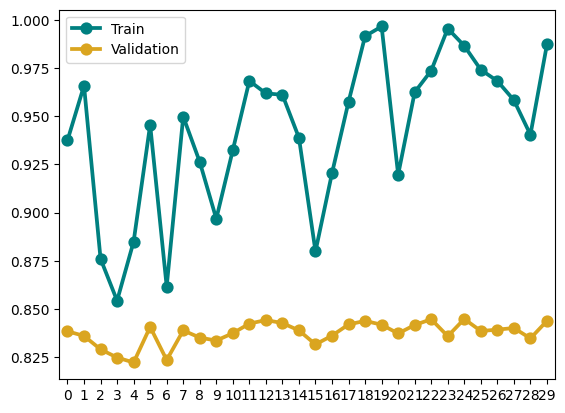

In [18]:
#6. Usar a tua point_plot com train e validation reais

validation_scores = optuna_sorted["value"].tolist()
train_scores = optuna_sorted["train_score"].tolist()
values_try = optuna_sorted["trial_number"].tolist()  # x-axis = trial index

point_plot(train_scores, validation_scores, values_try)

## **3.3 Random Forest**
### **3.3.1 Grid Search**

In [19]:
param_dist = {
    "n_estimators": [750, 1000, 1250, 1500],
    "max_depth": [5, 15, 20, 30, None],
    "max_features": ["sqrt", "log2", 0.1, 0.3, 0.5]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced_subsample"    # <<-- moved here (correct)
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,              # for a more “global” exploration
    cv=skf,                 # your existing StratifiedKFold
    scoring="accuracy",
    return_train_score=True,
    random_state=42,
    n_jobs=-1               # if you want parallelism
)

random_search.fit(X_enc, y)

best_params_rf = random_search.best_params_

### **3.3.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/RandomForest** file name **Random_Forest_Grid_Search_{timestamp}.xlsx**

In [20]:
results = pd.DataFrame(random_search.cv_results_)

# Keep only the columns we care about
cols = [
    "param_n_estimators",
    "param_max_depth",
    "param_max_features",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]
results = results[cols]

results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================

# 1. Define the directory where the file will be saved
output_dir = "../data/processed/RandomForest"

# 2. Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# 3. Create timestamp (YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 4. Build filename
filename = f"Random_Forest_Grid_Search_{timestamp}.xlsx"

# 5. Full path
filepath = os.path.join(output_dir, filename)

# 6. Save the Excel file
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")

results_sorted


Ficheiro guardado em: ../data/processed/RandomForest\Random_Forest_Grid_Search_20251201_141553.xlsx


,param_n_estimators,param_max_depth,param_max_features,mean_train_score,mean_test_score,std_test_score,rank_test_score
7,750,None,sqrt,1.000000,0.847365,0.011682,1
4,750,20,log2,0.996876,0.847223,0.009933,2
26,750,20,sqrt,0.996876,0.847223,0.009933,2
23,1250,20,sqrt,0.997018,0.846513,0.009358,4
3,1000,20,log2,0.997054,0.846513,0.010272,5
0,1500,None,sqrt,1.000000,0.846087,0.011176,6
29,750,30,0.3,1.000000,0.845377,0.011595,7
27,750,None,0.5,1.000000,0.845376,0.014646,8
5,1500,15,0.5,0.976005,0.845236,0.010845,9
12,1000,30,0.3,1.000000,0.845092,0.011343,10


### **3.3.3 Visualizing the Grid Search**

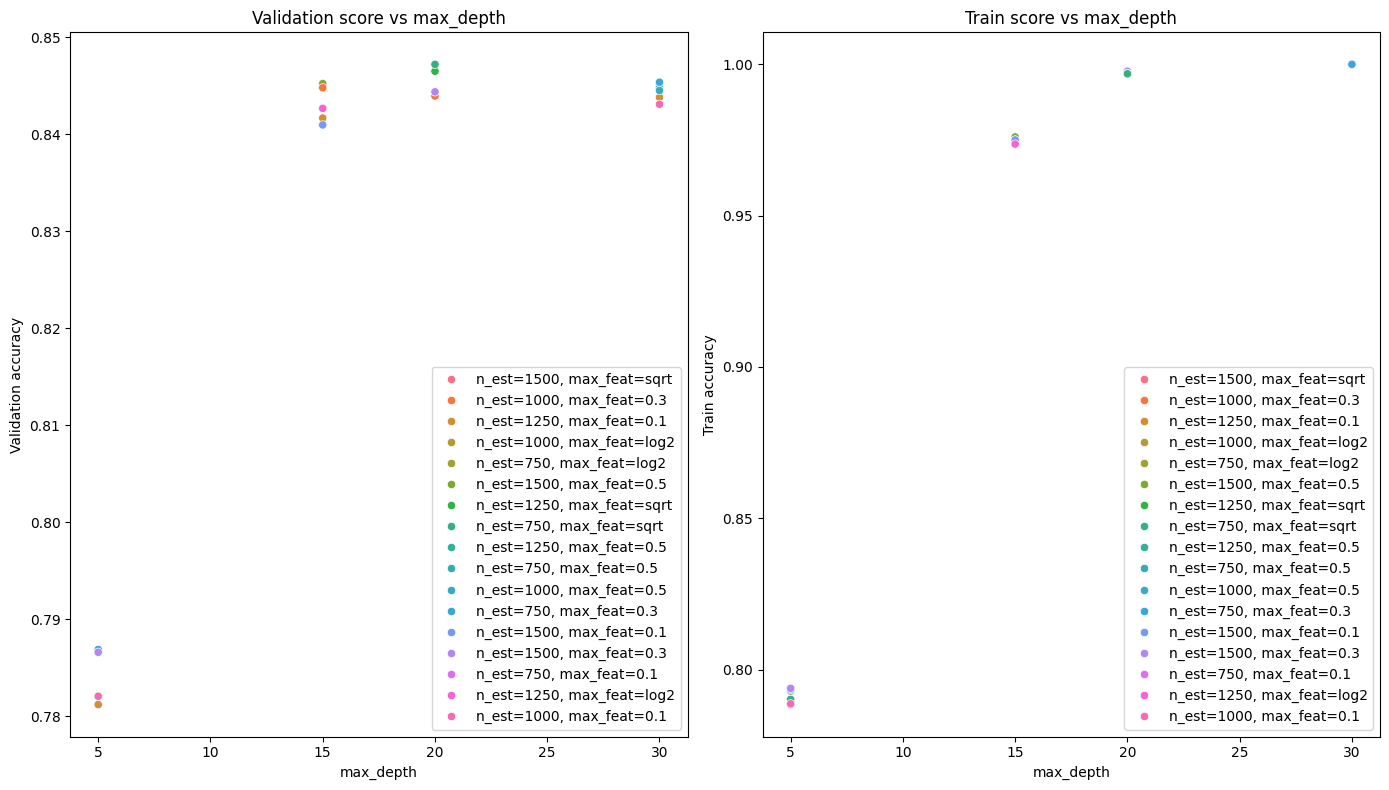

In [21]:
def combo_label(row):
    return f"n_est={row['param_n_estimators']}, max_feat={row['param_max_features']}"

results["combo"] = results.apply(combo_label, axis=1)


# results = DataFrame construído antes
# já tem as colunas: param_max_depth, mean_train_score, mean_test_score, combo

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# --- VALIDATION ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_test_score",
    hue="combo",
    ax=ax[0]
)

ax[0].set_title("Validation score vs max_depth")
ax[0].legend(loc="lower right")     # <<-- legenda do subplot 0
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("Validation accuracy")

# --- TRAIN ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_train_score",
    hue="combo",
    ax=ax[1]
)

ax[1].set_title("Train score vs max_depth")
ax[1].legend(loc="lower right")      # <<-- legenda do subplot 1
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("Train accuracy")

plt.tight_layout()
plt.show()


## **3.4 Logistic Regression (with StandardScaler)**
### **3.4.1 Grid Search**

In [22]:
# 1. Parameter grid
param_grid = [
    {
        "penalty": ["l2"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["l1"],
        "solver": ["liblinear", "saga"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0.1, 0.5, 0.9],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "class_weight": [None, "balanced"]
    },
    {
        "penalty": ["none"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "class_weight": [None, "balanced"]
    }
]

# 2. Model
log_reg = LogisticRegression(max_iter=1000)

# 3. Grid Search using your existing skf
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=skf,                     # <<-- your StratifiedKFold
    scoring="accuracy",
    return_train_score=True
)

grid.fit(X_enc, y)

best_params_log = grid.best_params_


c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Incr

### **3.4.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/Logistic_Regression_Optimization** file name **Logistic_Regression_Grid_Search_{timestamp}.xlsx**

In [23]:
results = pd.DataFrame(grid.cv_results_)

cols = [
    "param_C",
    "param_penalty",
    "param_solver",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]

results = results[cols]
results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================
# 1. Output directory
output_dir = "../data/processed/Logistic_Regression_Optimization"
os.makedirs(output_dir, exist_ok=True)

# 2. Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 3. Filename
filename = f"Logistic_Regression_Grid_Search_{timestamp}.xlsx"

# 4. Full path
filepath = os.path.join(output_dir, filename)

# 5. Save Excel
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")


results_sorted


Ficheiro guardado em: ../data/processed/Logistic_Regression_Optimization\Logistic_Regression_Grid_Search_20251201_143034.xlsx


,param_C,param_penalty,param_solver,mean_train_score,mean_test_score,std_test_score,rank_test_score
41,100.0,l2,newton-cg,0.842468,0.839982,0.011569,1
33,10.0,l2,newton-cg,0.842468,0.839840,0.011517,2
25,1.0,l2,newton-cg,0.841545,0.838847,0.011356,3
17,0.1,l2,newton-cg,0.840977,0.838846,0.011001,4
56,0.1,l1,liblinear,0.839522,0.837426,0.011008,5
...,...,...,...,...,...,...,...
105,NaN,none,saga,NaN,NaN,NaN,103
106,NaN,none,lbfgs,NaN,NaN,NaN,103
107,NaN,none,newton-cg,NaN,NaN,NaN,103
108,NaN,none,sag,NaN,NaN,NaN,103


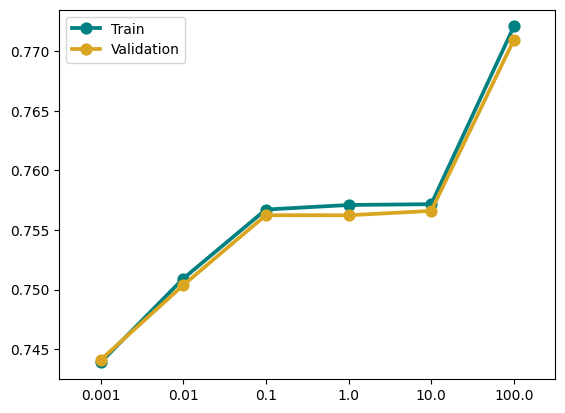

In [24]:
# 1) Put cv_results_ into a DataFrame
results = pd.DataFrame(grid.cv_results_)

# 2) Group by C and compute mean train/validation score per C
group = results.groupby("param_C").agg(
    mean_train=("mean_train_score", "mean"),
    mean_val=("mean_test_score", "mean")
).reset_index()

# 3) Prepare data for point_plot
values_try = group["param_C"].tolist()         # x-axis = C values
train_scores = group["mean_train"].tolist()    # y1 = train
validation_scores = group["mean_val"].tolist() # y2 = validation

# 4) Plot
point_plot(train_scores, validation_scores, values_try)

O C é o hiperparâmetro de regularização da Logistic Regression.

✔️ É o inverso da força de regularização.
✔️ Ou seja:

C pequeno → regularização forte → modelo mais simples

C grande → regularização fraca → modelo mais complexo

Como interpretar isto na prática?

 - Quando o dataset tem muito ruído → C pequeno é melhor

 - Quando tens muitas features → C pequeno evita overfitting

 - Quando tens dados simples bem separados → C grande dá mais precisão

 - Quando tens dados desbalanceados → C interage com class_weight e solver

In [25]:
# Criar DataFrame com resultados do GridSearch
# Put cv_results_ into a DataFrame
results = pd.DataFrame(grid.cv_results_)

# Keep only the columns we care about
plot_df = results[
    [
        "param_C",
        "param_penalty",
        "param_solver",
        "param_class_weight",
        "mean_train_score",
        "mean_test_score"
    ]
].copy()

# Sometimes param_C comes as object/string, ensure numeric
plot_df["param_C"] = plot_df["param_C"].astype(float)


In [26]:
# Melt into long format: one row per (C, penalty, solver, class_weight, dataset)
plot_long = plot_df.melt(
    id_vars=["param_C", "param_penalty", "param_solver", "param_class_weight"],
    value_vars=["mean_train_score", "mean_test_score"],
    var_name="dataset",
    value_name="score"
)

# Rename dataset labels to nicer names
plot_long["dataset"] = plot_long["dataset"].map(
    {
        "mean_train_score": "Train",
        "mean_test_score": "Validation"
    }
)


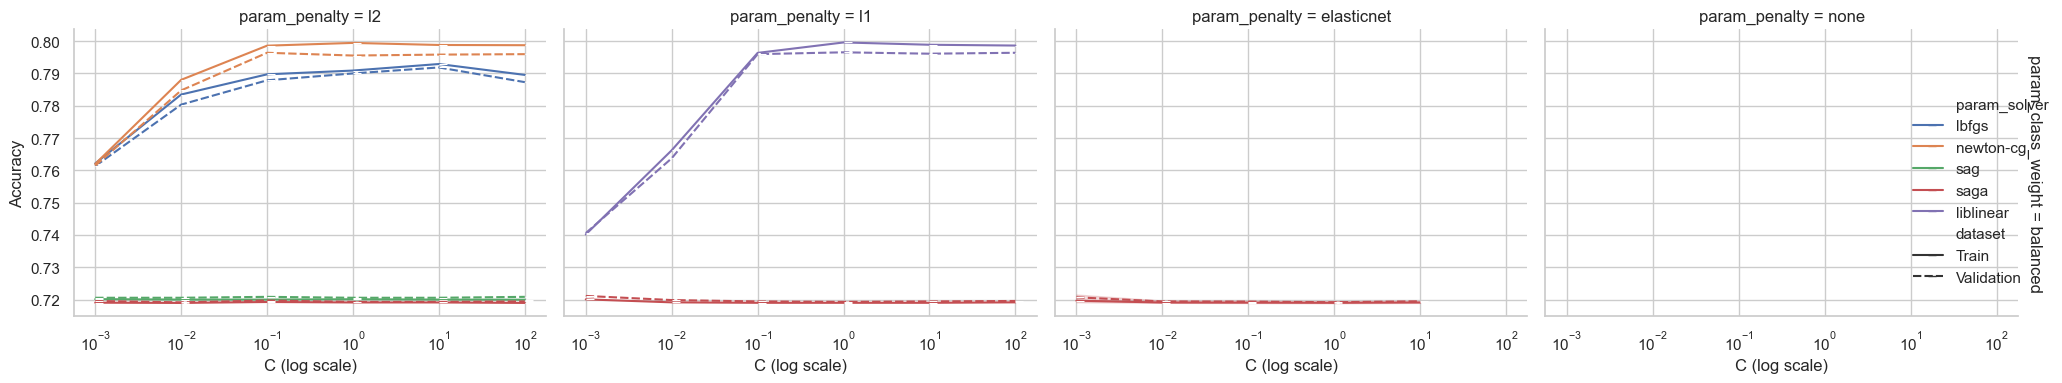

In [27]:
# Gráfico automático de overfitting (C × penalty × solver × class_weight)

sns.set(style="whitegrid")

g = sns.relplot(
    data=plot_long,
    x="param_C",
    y="score",
    hue="param_solver",
    style="dataset",          # Train vs Validation
    row="param_class_weight", # None vs balanced
    col="param_penalty",      # l1, l2, elasticnet, none
    kind="line",
    marker=True,
    facet_kws={"margin_titles": True},
    height=4,
    aspect=1.2
)

# Log scale for C and labels
for ax in g.axes.flat:
    ax.set_xscale("log")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


# **4 Final Models**
## **4.1 Best XGBoost Grid Search Parameters Model**

In [28]:
best_params = study.best_params
best_params

{'max_depth': 10,
 'learning_rate': 0.1820027635933747,
 'subsample': 0.7717449130372472,
 'colsample_bytree': 0.7744021560064709,
 'n_estimators': 529,
 'min_child_weight': 6,
 'gamma': 1.1964045083468418,
 'reg_lambda': 1.0103749227144747,
 'reg_alpha': 0.0018647097616731499}

In [29]:
from xgboost import XGBClassifier

final_xgb = XGBClassifier(
    **best_params,                 # best hyperparameters from Optuna
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

## **4.2 Best Random Forest Grid Search Parameters Model**

In [30]:
best_params_rf

{'n_estimators': 750, 'max_features': 'sqrt', 'max_depth': None}

In [31]:
final_rf = RandomForestClassifier(
    **best_params_rf,
    class_weight="balanced_subsample",  # se usaste isto no modelo base
    random_state=42,
    n_jobs=-1
)

## **4.3 Best Logistic Regression Grid Search Parameters Model**

In [32]:
best_params_log

{'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}

In [33]:
best_params_log = grid.best_params_

final_log_reg = LogisticRegression(
    **best_params_log,
    max_iter=1000
)

## **4.4 Select Winner Model**
### **4.4.1 Train Optimized models on subsets of features**

In [34]:
# =======================================
# 0. Ensure output folder exists
# =======================================

output_dir = "../data/processed/Optimized_Model_results"
os.makedirs(output_dir, exist_ok=True)

# =======================================
# 1. Build dictionary of subsets (encoded only)
# =======================================

subsets_for_models = {
    "all_data_enc": X_enc,

    # Embedded subsets
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper subsets
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}

# =======================================
# 2. Evaluate all models on all subsets
# =======================================

models = [final_xgb, final_rf, final_log_reg]
scales = [False, False, True]

Final_models_results_list = []

for subset_name, X_sub in subsets_for_models.items():
    print(f"Running models for subset: {subset_name} (shape={X_sub.shape})")

    tmp_results = pd.DataFrame(
        index=["XGB", "RF", "LOG"],
        columns=["Train F1", "Validation (F1)"]
    )

    tmp_results = show_results(tmp_results, X_sub, y, skf, models, scales)

    tmp_results["Subset"] = subset_name
    tmp_results["Model"] = tmp_results.index

    Final_models_results_list.append(tmp_results.reset_index(drop=True))

# =======================================
# 3. Final results table
# =======================================

final_models_results = pd.concat(Final_models_results_list, ignore_index=True)
final_models_results = final_models_results[["Subset", "Model", "Train F1", "Validation (F1)"]]
final_models_results.set_index(["Subset", "Model"], inplace=True)

# =======================================
# 4. Timestamp
# =======================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =======================================
# 5. Save results inside folder
# =======================================

results_xlsx = os.path.join(output_dir, f"final_results_{timestamp}.xlsx")
features_xlsx = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.xlsx")

# Save model results
final_models_results.to_excel(results_xlsx)

# Save feature compositions
subset_feature_dict = {}

subset_feature_dict["all_data"] = list(X.columns)
subset_feature_dict["all_data_enc"] = list(X_enc.columns)

for name, df in subsets_for_models.items():
    subset_feature_dict[name] = list(df.columns)

subset_feature_df = (
    pd.DataFrame.from_dict(subset_feature_dict, orient="index")
    .transpose()
)

#subset_feature_df.to_csv(features_csv, index=False)
subset_feature_df.to_excel(features_xlsx, index=False)

print("Saved files:")
print(f" - {results_xlsx}")
print(f" - {features_xlsx}")
final_models_results


Running models for subset: all_data_enc (shape=(7043, 33))
Running models for subset: xgb_embed (shape=(7043, 15))
Running models for subset: rf_embed (shape=(7043, 15))
Running models for subset: log_embed (shape=(7043, 15))
Running models for subset: consensus_3of3_embed (shape=(7043, 32))
Running models for subset: consensus_2of3_embed (shape=(7043, 33))
Running models for subset: consensus_topN_embed (shape=(7043, 20))
Running models for subset: xgb_wrapper (shape=(7043, 21))
Running models for subset: rf_wrapper (shape=(7043, 27))
Running models for subset: log_wrapper (shape=(7043, 28))
Running models for subset: consensus_3of3_wrapper (shape=(7043, 16))
Running models for subset: consensus_2of3_wrapper (shape=(7043, 27))
Running models for subset: consensus_topN_wrapper (shape=(7043, 25))
Saved files:
 - ../data/processed/Optimized_Model_results\final_results_20251201_143329.xlsx
 - ../data/processed/Optimized_Model_results\subset_feature_composition_20251201_143329.xlsx


Train F1 Validation (F1)
Subset                 Model                                
all_data_enc           XGB     0.975 +/- 0.0  0.717 +/- 0.01
                       RF        1.0 +/- 0.0  0.678 +/- 0.02
                       LOG    0.691 +/- 0.01  0.687 +/- 0.02
xgb_embed              XGB     0.907 +/- 0.0  0.691 +/- 0.02
                       RF        1.0 +/- 0.0  0.672 +/- 0.02
                       LOG     0.679 +/- 0.0  0.678 +/- 0.02
rf_embed               XGB     0.968 +/- 0.0  0.695 +/- 0.02
                       RF        1.0 +/- 0.0  0.672 +/- 0.02
                       LOG      0.66 +/- 0.0  0.654 +/- 0.02
log_embed              XGB     0.721 +/- 0.0  0.679 +/- 0.01
                       RF      0.765 +/- 0.0  0.662 +/- 0.01
                       LOG     0.658 +/- 0.0  0.658 +/- 0.01
consensus_3of3_embed   XGB     0.977 +/- 0.0  0.706 +/- 0.01
                       RF        1.0 +/- 0.0  0.676 +/- 0.02
                       LOG    0.691 +/- 0.01  0.687 +/- 0.02
consensus_2of3_embed   XGB     0.975 +/- 0.0  0.717 +/- 0.02
                       RF        1.0 +/- 0.0  0.673 +/- 0.02
                       LOG    0.691 +/- 0.01  0.687 +/- 0.02
consensus_topN_embed   XGB      0.97 +/- 0.0  0.705 +/- 0.02
                       RF        1.0 +/- 0.0  0.673 +/- 0.02
                       LOG     0.689 +/- 0.0  0.682 +/- 0.01
xgb_wrapper            XGB     0.954 +/- 0.0  0.711 +/- 0.01
                       RF        1.0 +/- 0.0  0.677 +/- 0.02
                       LOG    0.681 +/- 0.01  0.675 +/- 0.02
rf_wrapper             XGB     0.974 +/- 0.0  0.706 +/- 0.01
                       RF        1.0 +/- 0.0  0.676 +/- 0.02
                       LOG     0.682 +/- 0.0  0.679 +/- 0.01
log_wrapper            XGB     0.959 +/- 0.0  0.702 +/- 0.02
                       RF        1.0 +/- 0.0  0.676 +/- 0.02
                       LOG    0.689 +/- 0.01  0.683 +/- 0.02
consensus_3of3_wrapper XGB      0.94 +/- 0.0  0.707 +/- 0.01
                       RF        1.0 +/- 0.0   0.68 +/- 0.02
                       LOG     0.673 +/- 0.0  0.672 +/- 0.02
consensus_2of3_wrapper XGB     0.962 +/- 0.0   0.71 +/- 0.01
                       RF        1.0 +/- 0.0  0.683 +/- 0.02
                       LOG    0.684 +/- 0.01  0.678 +/- 0.02
consensus_topN_wrapper XGB     0.972 +/- 0.0  0.711 +/- 0.01
                       RF        1.0 +/- 0.0  0.676 +/- 0.02
                       LOG    0.692 +/- 0.01  0.687 +/- 0.02

### **4.4.2 Get Best model and subset of features from previous training**

In [35]:
models_dict = {
    "XGB": final_xgb,
    "RF": final_rf,
    "LOG": final_log_reg
}

def get_best_model_and_data(results_df, subsets_dict, models_dict, metric_col="Validation (F1)"):
    """
    Picks the best (Subset, Model) based on a validation metric,
    then returns:
      - best_info: dict with metadata
      - model_best: a CLONE of the corresponding fitted model template
      - X_best: feature subset (DataFrame)
    """
    flat = results_df.reset_index()

    # Handle metrics stored as strings like '0.718 +/- 0.01'
    metric_numeric = (
        flat[metric_col]
        .astype(str)
        .str.split()
        .str[0]
        .astype(float)
    )

    best_idx = metric_numeric.idxmax()
    best_row = flat.loc[best_idx]

    subset_name = best_row["Subset"]
    model_name = best_row["Model"]

    best_info = {
        "subset": subset_name,
        "model": model_name,
        "train_score": best_row["Train F1"],
        "val_score_str": best_row[metric_col],
        "val_score_num": float(str(best_row[metric_col]).split()[0])
    }

    X_best = subsets_dict[subset_name]
    model_template = models_dict[model_name]
    model_best = clone(model_template)   # fresh model, same hyperparams

    return best_info, model_best, X_best




In [39]:
best_info, best_model_final, X_best = get_best_model_and_data(
    final_models_results,
    subsets_for_models,
    models_dict,
    metric_col="Validation (F1)"
)

best_info


{'subset': 'all_data_enc',
 'model': 'XGB',
 'train_score': '0.975 +/- 0.0',
 'val_score_str': '0.717 +/- 0.01',
 'val_score_num': 0.717}

### **4.4.3 Saving info and final model for future analysis and evaluation**

In [40]:
# ================================
# 1) Pick best combo & train final
# ================================


# NOTA: O objeto que indica o modelo final é: best_model_final (criado abaixo)
best_info, best_model_final, X_best = get_best_model_and_data(
    final_models_results,
    subsets_for_models,
    models_dict,
    metric_col="Validation (F1)"
)

best_model_final.fit(X_best, y.ravel())

# Extract info
subset_name = best_info["subset"]
model_name = best_info["model"]
train_f1 = best_info["train_score"]
val_f1_str = best_info["val_score_str"]
val_f1_num = best_info["val_score_num"]

n_samples = X_best.shape[0]
n_features = X_best.shape[1]
features_used = list(X_best.columns)

# ================================
# 2) Print summary
# ================================

print("==============================================")
print(" BEST MODEL — FINAL SELECTION SUMMARY")
print("==============================================")
print(f"• Best Model:           {model_name}")
print(f"• Best Feature Subset:  {subset_name}")
print(f"• Nº Features Used:     {n_features}")
print(f"• Nº Samples Used:      {n_samples}")
print("----------------------------------------------")
print(f"• Cross-Validation Train F1:      {train_f1}")
print(f"• Cross-Validation Validation F1: {val_f1_str}  (numeric: {val_f1_num:.3f})")
print("----------------------------------------------")
print("• Feature list:")
for f in features_used:
    print(f"   - {f}")
print("==============================================")

# ================================
# 3) Save summary to Excel
# ================================

summary_filename = os.path.join(
    output_dir,
    f"best_model_summary_{timestamp}.xlsx"
)

summary_df = pd.DataFrame({
    "Item": [
        "Best Model",
        "Best Subset",
        "Train F1 (CV)",
        "Validation F1 (CV)",
        "Validation F1 (numeric)",
        "Nº Samples",
        "Nº Features"
    ],
    "Value": [
        model_name,
        subset_name,
        train_f1,
        val_f1_str,
        val_f1_num,
        n_samples,
        n_features
    ]
})

with pd.ExcelWriter(summary_filename) as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    pd.DataFrame({"Features Used": features_used}).to_excel(
        writer, sheet_name="Feature_List", index=False
    )

print(f"Best model summary saved to:\n  {summary_filename}")


C:\Users\sergi\AppData\Local\Temp\ipykernel_21580\3447853098.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  best_model_final.fit(X_best, y.ravel())


 BEST MODEL — FINAL SELECTION SUMMARY
• Best Model:           XGB
• Best Feature Subset:  all_data_enc
• Nº Features Used:     33
• Nº Samples Used:      7043
----------------------------------------------
• Cross-Validation Train F1:      0.975 +/- 0.0
• Cross-Validation Validation F1: 0.717 +/- 0.01  (numeric: 0.717)
----------------------------------------------
• Feature list:
   - demo_age
   - demo_married
   - demo_number_of_dependents
   - loc_zip_code
   - loc_latitude
   - loc_longitude
   - svc_referred_a_friend
   - svc_number_of_referrals
   - svc_tenure_in_months
   - svc_phone_service
   - svc_avg_monthly_long_distance_charges
   - svc_multiple_lines
   - svc_internet_service
   - svc_avg_monthly_gb_download
   - svc_online_security
   - svc_online_backup
   - svc_device_protection_plan
   - svc_premium_tech_support
   - svc_streaming_tv
   - svc_streaming_movies
   - svc_streaming_music
   - svc_unlimited_data
   - svc_paperless_billing
   - svc_monthly_charge
   - Is_w

# **5 Export Model for future evaluation**

In [41]:
# ================================
# SAVE ARTIFACTS FOR MODEL EVALUATION
# ================================


# 1. Save best model (pickle)
model_path = os.path.join(output_dir, f"best_model_final_{timestamp}.pkl")
joblib.dump(best_model_final, model_path)

# 2. Save best subset of features (X_best)
X_best_path = os.path.join(output_dir, f"X_best_{timestamp}.csv")
X_best.to_csv(X_best_path, index=False)

# 3. Save full target vector (y)
y_path = os.path.join(output_dir, f"y_full_{timestamp}.csv")
pd.DataFrame({"target": y}).to_csv(y_path, index=False)

# 4. (Opcional mas recomendado) – guardar metadados do melhor modelo
metadata = {
    "timestamp": timestamp,
    "best_model_name": best_info["model"],
    "best_subset_name": best_info["subset"],
    "train_f1_cv": best_info["train_score"],
    "val_f1_cv_str": best_info["val_score_str"],
    "val_f1_cv_num": best_info["val_score_num"],
    "n_samples": int(X_best.shape[0]),
    "n_features": int(X_best.shape[1]),
    "model_path": model_path,
    "X_best_path": X_best_path,
    "y_path": y_path,
}

metadata_path = os.path.join(output_dir, f"best_model_metadata_{timestamp}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print("\n==============================================")
print("Artifacts saved for MODEL EVALUATION:")
print(" - Best model:          ", model_path)
print(" - Best feature subset: ", X_best_path)
print(" - Full target vector:  ", y_path)
print(" - Metadata JSON:       ", metadata_path)
print("==============================================\n")



Artifacts saved for MODEL EVALUATION:
 - Best model:           ../data/processed/Optimized_Model_results\best_model_final_20251201_143329.pkl
 - Best feature subset:  ../data/processed/Optimized_Model_results\X_best_20251201_143329.csv
 - Full target vector:   ../data/processed/Optimized_Model_results\y_full_20251201_143329.csv
 - Metadata JSON:        ../data/processed/Optimized_Model_results\best_model_metadata_20251201_143329.json



<!-- MODELO: Secção principal numerada -->
<!-- 
<h2 style="background-color:#1f77b4; color:white; padding:10px; border-radius:6px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Secção com linha colorida -->
<!-- 
<h2 style="color:#ff7f0e; border-bottom: 3px solid #ff7f0e; padding-bottom:4px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Subsecção -->
<!-- 
<h3 style="color:#2ca02c; margin-top:10px;">
    X.Y Nome da Subsecção
</h3>
-->

<!-- MODELO: Caixa de Nota -->
<!-- 
<div style="border-left: 5px solid #1f77b4; padding:10px; background-color:#f5f9ff; margin:15px 0;">
    <b>Nota:</b> Texto da nota.
</div>
-->